Experimental doc2vec classifier

### Import packages etc

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string, os, re, multiprocessing
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from stop_words import get_stop_words

import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

### Define various functons

In [79]:
def strip_formatting(df_row):
    words = df_row.str.replace('[{}]'.format(string.punctuation), ' ')
    lines = words.str.replace("\n", " ")
    cleaned = lines.str.lower()
    return cleaned

def splitter(row, n):
    words = re.sub("[^\w]", " ",  row).split()
    output = [words[start:start+n] for start in range(0, len(words), n)]
    return output

def split_data_frame_list(df,
                       target_column,
                      output_type=float):
    '''
    Accepts a column with multiple types and splits list variables to several rows.

    df: dataframe to split
    target_column: the column containing the values to split
    output_type: type of all outputs
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row.
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []
    def split_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
          for s in split_row:
              new_row = row.to_dict()
              new_row[target_column] = s
              row_accumulator.append(new_row)
          if split_row == []:
              new_row = row.to_dict()
              new_row[target_column] = None
              row_accumulator.append(new_row)
        else:
          new_row = row.to_dict()
          new_row[target_column] = split_row
          row_accumulator.append(new_row)
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
    return new_df

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

### Preprocessing step from other pipeline

In [80]:
# Import metadata as DF; drop files that are restricted (part of EEBO Phase II)
metadata = pd.read_csv('/Users/au564346/Documents/research/LINK/data/LINK-master/dat/VEP_expanded_drama_1700_v2_txt/metadata/EM_Drama.Metadata.csv', sep=";")
metadata = metadata[metadata.status != 'Restricted']

In [81]:
metadata.head()

,TCP,estc,Wiggins number,author,author 2,author 3,author 4,author 5,translator,adaptation,...,date of text used,play company 1,play company 2,theatre,metre,rhyme,notes,text_name,status,Unnamed: 33
0,A36644,Wing D2305; ESTC R11613,NaN,"'J.D.' (Dover, John?)",NaN,NaN,NaN,NaN,NaN,NaN,...,1674,King's,NaN,NaN,NaN,NaN,NaN,A36644.headed.txt,Free,NaN
2,A05801,S104360,NaN,"A., R.",NaN,NaN,NaN,NaN,NaN,NaN,...,1615,Prince Charles's Men (first),Prince Henry's Men,NaN,NaN,NaN,TCP transcription exists - have requested play...,A05801.headed.txt,Free,NaN
7,A18589,S104972,NaN,"Amerie, Robert","Davies, Richard",NaN,NaN,NaN,NaN,NaN,...,1610,NaN,NaN,NaN,NaN,NaN,NaN,A18589.headed.txt,Free,NaN
8,A01513,S105691,419,"Ariosto, Ludovico",NaN,NaN,NaN,NaN,"Gascoigne, George",NaN,...,1573,NaN,NaN,Gray's Inn,prose,no,NaN,A01513.headed_005_play_001.txt,Free,NaN
9,A25808,R7554,NaN,Aristophanes,NaN,NaN,NaN,NaN,"Randolph, Thomas; J., F.",NaN,...,1651,NaN,NaN,NaN,NaN,NaN,NaN,A25808.headed.txt,Free,NaN


In [82]:
# Create DF of one play per line
plays = pd.DataFrame(columns=['documents'])
path = '/Users/au564346/Documents/research/LINK/data/drama_queens/Corpus without MA og anon'
for filename in os.listdir(path):
    if not filename.startswith('.'):
        with open(os.path.join(path, filename)) as f:
            text = f.read()
            current_df = pd.DataFrame({'documents': [text]})
            plays = plays.append(current_df, ignore_index=True)

In [83]:
# Join up plays with author and genre metadata
plays['genre'] = metadata["genre"].to_frame().reset_index(drop=True)
plays['author'] = metadata["author"].to_frame().reset_index(drop=True)
plays['year'] = metadata["date of writing"].to_frame().reset_index(drop=True).astype(int)

In [8]:
# Clean strings using strip_formatting function
plays['text'] = [cleaned for cleaned in strip_formatting(plays["text"])]

In [12]:
# Extract specifc subset of years
years = list(range(1590, 1620))
subset = plays.loc[plays.year.isin(years)].reset_index()
del subset["index"]
# Split string into list of lists using splitter function
subset['text'] = subset["text"].apply(lambda x: splitter(x, 1000))
# Explode DataFrame and keep author/genre metada in place
corpus = split_data_frame_list(subset, target_column='text')
# List of lists back to string
corpus["text"] = corpus["text"].apply(lambda x: ' '.join(map(str, x)))

In [84]:
## This can probably be rewritten as a function
## Could be including in split_data_frame_list function?
# Split string into list of lists using splitter function
plays['documents'] = plays['documents'].apply(lambda x: splitter(x, 1000))
# Explode DataFrame and keep author/genre metada in place
corpus = split_data_frame_list(plays, target_column='documents')
# List of lists back to string
corpus['documents'] = corpus['documents'].apply(lambda x: ' '.join(map(str, x)))

NameError: ("name 'target_column' is not defined", 'occurred at index 0')

In [73]:
corpus.head()

,author,documents,genre,year
0,"'J.D.' (Dover, John?)",THough Plays and Prologues never did more abou...,CO,1674
1,"'J.D.' (Dover, John?)",for ought I can perceive to leave me a bent Ni...,CO,1674
2,"'J.D.' (Dover, John?)",out of Contribution but by taking up his Fathe...,CO,1674
3,"'J.D.' (Dover, John?)",the Danger of the Times and some other Obstruc...,CO,1674
4,"'J.D.' (Dover, John?)",showed thee this bewitching Name at the bottom...,CO,1674


### Corpus size and visualise

In [52]:
corpus['"documents"'].apply(lambda x: len(x.split(' '))).sum()

15249283

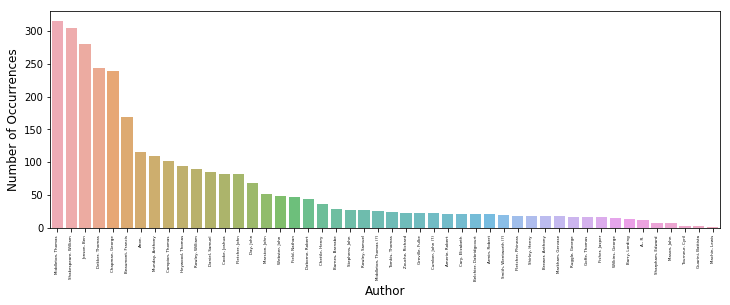

In [10]:
cnt_aut = corpus['author'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_aut.index, cnt_aut.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author', fontsize=12)
plt.xticks(rotation=90, fontsize=4)
plt.show();

### Stopwords

In [12]:
# User defined stopwords
# Create list of stopwords from various sources
stop_1 = get_stop_words("english")
stop_2 = stopwords.words("english")
#Combine as one list
stops = list(set(stop_1 + stop_2))
# Extend as you see fit!
stops.extend(['thou', 'thy','thee', 'sir', 'lord', 'lady', 'will', 'shall', 's', 'art'])
# Stopwords
corpus["text"] = corpus["text"].apply(lambda x: " ".join([item for item in (str(x)).split(" ") if item not in stops]))
corpus.to_csv("/Users/au564346/Desktop/corpus.csv", header=True)

### Split into train and test

Test with oversample?

In [13]:
train, test = train_test_split(corpus, test_size=0.2, random_state=42)

In [14]:
test

,author,genre,text,year
314,"Greville, Fulke",TR,boiling beating waves passion w calm esculapiu...,1596
4284,"Middleton, Thomas",CO,living look upon death wisdom forget endeare l...,1614
734,"Jonson, Ben",EN,death seize infamy let death come tamely suffe...,1604
151,"Shakespeare, William",TC,punishments men applauded prescribe laws force...,1613
109,"Fletcher, John",CO,dotage withered brain penthea forbad presence ...,1611
596,"Barnes, Barnabe",TR,kill bind alive windore hang forth devising mo...,1606
2347,"Shakespeare, William",HI,purpose often intelligence yet bridle prevail ...,1599
3237,"Chapman, George",CO,self creature therefore sooner let know may us...,1605
2118,"Shakespeare, William",CO,men milisent suffer spiders chamber count prof...,1598
3281,"Chapman, George",CO,matches soever guardians make em hope father f...,1602


In [15]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.author]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.author]), axis=1)

### Define model, run, inspect

In doc2vec land, dbow is equivalent to CBOW word2vec

In [16]:
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in train_tagged.values])

In [17]:
%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 3455/3455 [00:00<00:00, 1744891.07it/s]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 7.87 µs



100%|██████████| 3455/3455 [00:00<00:00, 1714746.22it/s]


In [18]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [22]:
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [23]:
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.06712962962962964
Testing F1 score: 0.06228316442031905


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Distributed memory model

Equivalent to skip-gram word2vec

In [24]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 3455/3455 [00:00<00:00, 1374236.16it/s]


In [25]:
%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 3455/3455 [00:00<00:00, 1417659.98it/s]

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.11 µs



100%|██████████| 3455/3455 [00:00<00:00, 1744051.07it/s]


In [26]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.6550925925925926
Testing F1 score: 0.6594176095542204


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [23]:
#model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
#model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

### Concatenate

In [28]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

In [29]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [30]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [31]:
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.6921296296296297
Testing F1 score: 0.6747483413083705


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Predictions!

In [212]:
file = open("/Users/au564346/Documents/research/LINK/LINK-master/dat/VEP_expanded_drama_1700_v2_txt/corpus/A04520.headed_002_part_001.txt").read()

In [310]:
val = int(len(file)*0.1)

In [311]:
sentences = splitter(file, val)

In [305]:
cleaned = [word for word in sentences if word not in stops]

In [306]:
inferred_vector = [model_dmm.infer_vector(sent) for sent in cleaned]

In [307]:
predictions = []
for i in range(len(cleaned)):
    p = model_dmm.docvecs.most_similar(positive=[model_dmm.infer_vector(cleaned[i])],topn=5)
    predictions.append(p)

In [308]:
predictions

[[('Peele, George', 0.3396719694137573),
  ('Shirley, Henry', 0.284935861825943),
  ('Stephens, John', 0.2832583785057068),
  ('Porter, Henry', 0.2815849483013153),
  ('Shakespeare, William', 0.27401331067085266)],
 [('Stephens, John', 0.3410383462905884),
  ('Shirley, Henry', 0.313082218170166),
  ('Fisher, Jasper', 0.3027588129043579),
  ('A., R.', 0.285976767539978),
  ('Porter, Henry', 0.2854048013687134)]]

In [297]:
l = []
for row in range(len(predictions)):
    i, j = predictions[row][0]
    arr = np.array([i, j])
    l.append(arr)

In [298]:
data = pd.DataFrame(l)
data.columns = ["author", "prediction%"]
data["prediction%"] = data["prediction%"].astype('float')
data['author'] = [x.strip('(?)') for x in data["author"]]
data['author'] = [x.strip(' ') for x in data["author"]]

In [299]:
data['count'] = data.groupby('author')['author'].transform('count')

In [300]:
data["segment%"] = data["count"]/len(data)

In [301]:
data["author"].mode()

0    Peele, George
dtype: object

In [302]:
data

,author,prediction%,count,segment%
0,"Marston, John",0.352833,1,0.052632
1,"Peele, George",0.342156,3,0.157895
2,"Greville, Fulke",0.351919,1,0.052632
3,"Marlowe, Christopher",0.246548,1,0.052632
4,"Peele, George",0.202971,3,0.157895
5,"Porter, Henry",0.131705,2,0.105263
6,"Porter, Henry",0.289495,2,0.105263
7,"Jonson, Ben",0.357776,1,0.052632
8,"Smith, Wentworth",0.289037,1,0.052632
9,"Stephens, John",0.182706,2,0.105263
